In [4]:
import pandas as pd
import os

# Get the current working directory
script_dir = os.getcwd()

# Navigate up one level to the parent directory
parent_dir = os.path.dirname(script_dir)

# Construct the path to noticias_pre_processadas.csv
caminho_csv = os.path.join(parent_dir, "noticias_pre_processadas.csv")

# Read the CSV file into a DataFrame
df = pd.read_csv(caminho_csv)


In [5]:
df.head()

,Texto,Categoria
0,O Podemos decidiu expulsar o deputado federal ...,true
1,"Bolsonaro é um liberal completo, diz president...",true
2,Ministro do STF libera Andrea Neves de prisão ...,true
3,"Apesar da abundância, cresce preocupação com p...",true
4,"Por que Harvard e MIT levarão Dilma, Moro e Su...",true


In [6]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

df['label'] = le.fit_transform(df['Categoria'])

In [7]:
df['Categoria'].unique(), df['label'].unique()

(array(['true', 'fake'], dtype=object), array([1, 0]))

In [8]:
df.drop(df.columns[1], axis=1, inplace=True)
df.head()

,Texto,label
0,O Podemos decidiu expulsar o deputado federal ...,1
1,"Bolsonaro é um liberal completo, diz president...",1
2,Ministro do STF libera Andrea Neves de prisão ...,1
3,"Apesar da abundância, cresce preocupação com p...",1
4,"Por que Harvard e MIT levarão Dilma, Moro e Su...",1


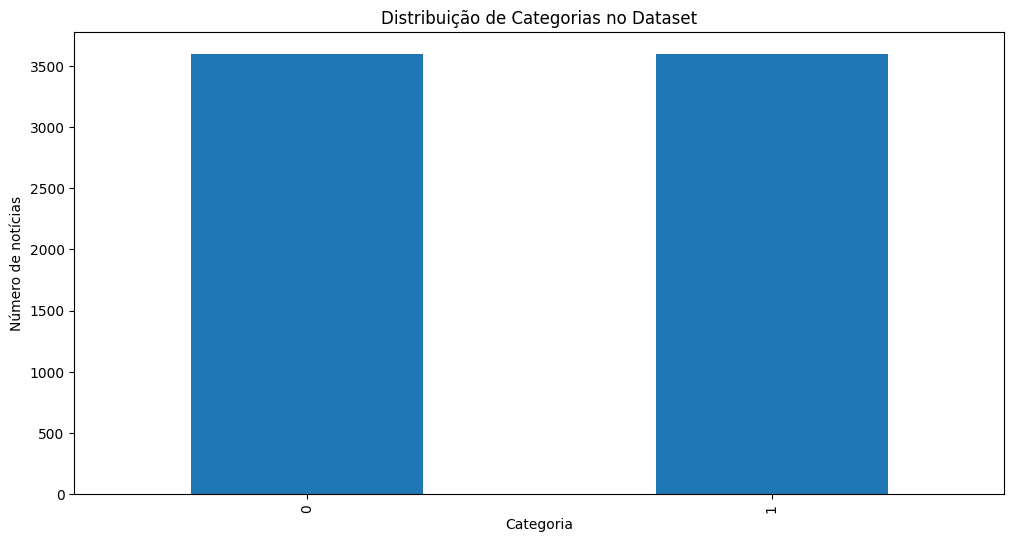

In [9]:
import matplotlib.pyplot as plt

category_counts = df['label'].value_counts()

plt.figure(figsize=(12,6))
category_counts.plot(kind='bar')
plt.xlabel('Categoria')
plt.ylabel('Número de notícias')
plt.title('Distribuição de Categorias no Dataset')
plt.show()

In [10]:
import string
import spacy
import unicodedata
from tqdm import tqdm
import numpy as np

# Habilita suporte do tqdm para os métodos de progressão do pandas (como progress_aplly)
tqdm.pandas()

# Carrega modelo de linguagem 'pt_core_news_lg' do spacy para processamento de texto em português
# Desabilita os componentes 'parser' e 'ner', já que não são necessários para a lematização
spacy_nlp_model = spacy.load("pt_core_news_lg", disable=["parser", "ner"])

def preprocess_data(df, text_column):
    """
    Realiza o pré-processamento dos dados de um texto em um Dataframe do Pandas.
    Remove pontuação, números e palavras comuns (stop words), converte para minúsculas, remove 
    acentos e símbolos diversos, e aplica lematização.
    """

    # Cria tabela de tradução que mapeia cada caractere de pontuação do módulo 'string.ponctuation'
    # para 'None' (ou seja, remove-os do texto).
    print("Removendo pontuação...")
    translator = str.maketrans('', '', string.punctuation)
    df[text_column] = df[text_column].progress_apply(lambda x: x.translate(translator))

    print("Removendo números...")
    translator = str.maketrans('', '', string.digits)
    df[text_column] = df[text_column].progress_apply(lambda x: x.translate(translator))

    print("Removendo acentos e símbolos diversos...")
    def remove_accents_and_symbols(text):
        try:
            # Normaliza a string para a forma NFKD e mantém apenas caracteres que não são diacríticos
            # nem combinam caracteres com diacríticos
            return ''.join(c for c in unicodedata.normalize('NFKD', text) if not unicodedata.combining(c) and unicodedata.category(c) != 'Mn')
        except TypeError:
            # Se não for possível normalizar um caractere, retorna uma string vazia
            return ''
        # Aplica a função 'remove_accents_and_symbols' na coluna 'text_column'
    df[text_column] = df[text_column].progress_apply(lambda x: remove_accents_and_symbols(x))
    
    print("Convertendo para minúsculas...")
    df[text_column] = df[text_column].progress_apply(lambda x: x.lower())

    print("Computando Lematização...")
    def lemmatize_text(doc):
        return [token.lemma_ for token in doc if not token.is_stop]

    n_chunks = 10  # Ajuste esse valor de acordo com o tamanho da base de dados e a memória disponível no sistema
    chunks = np.array_split(df, n_chunks) # Divide o dataframe em várias partes

    processed_chunks = []
    for i, chunk in enumerate(chunks):
        print(f"Processando segmento {i + 1} de {n_chunks}")
        processed_chunk = chunk.copy() # Cria uma cópia para realizar o processamento
        
        #  Aplica a função 'lemmatize_text' a cada documento processado pelo spaCy (usando 'spacy_nlp_model.pipe') e
        # atribui os resultados (uma lista de palavras lematizadas) à coluna 'text_column' do DataFrame 'processed_chunk'.
        # O tqdm é utilizado para exibir uma barra de progresso durante o processamento dos documentos.
        processed_chunk[text_column] = [lemmatize_text(doc) for doc in tqdm(spacy_nlp_model.pipe(chunk[text_column].astype(str), batch_size=100, disable=['parser', 'ner']), total=len(chunk[text_column]))]

        # Junta as partes em uma lista, para formar o dataframe final
        processed_chunks.append(processed_chunk)

    concatenated_df = pd.concat(processed_chunks) # Concatenar os DataFrames processados
    df[text_column] = concatenated_df[text_column] # Atribuir a coluna 'data' processada de volta ao dataframe original
    
    print("Remover tokens com espaços vazios...")
    df['Texto'] = df['Texto'].progress_apply(lambda x: [token for token in x if token.strip()])

In [11]:
preprocess_data(df, 'Texto') # Realiza o pré-processamento

Removendo pontuação...


100%|██████████| 7199/7199 [00:01<00:00, 3839.43it/s]


Removendo números...


100%|██████████| 7199/7199 [00:01<00:00, 4185.46it/s]


Removendo acentos e símbolos diversos...


100%|██████████| 7199/7199 [00:05<00:00, 1208.90it/s]


Convertendo para minúsculas...


100%|██████████| 7199/7199 [00:00<00:00, 53740.78it/s]
c:\Users\mathe\OneDrive\Área de Trabalho\TCC\Detector-de-Fake-News\.venv\lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Computando Lematização...
Processando segmento 1 de 10


100%|██████████| 720/720 [00:54<00:00, 13.32it/s]


Processando segmento 2 de 10


100%|██████████| 720/720 [00:37<00:00, 19.12it/s]


Processando segmento 3 de 10


100%|██████████| 720/720 [00:35<00:00, 20.13it/s]


Processando segmento 4 de 10


100%|██████████| 720/720 [00:39<00:00, 18.24it/s]


Processando segmento 5 de 10


100%|██████████| 720/720 [00:46<00:00, 15.55it/s]


Processando segmento 6 de 10


100%|██████████| 720/720 [00:06<00:00, 109.87it/s]


Processando segmento 7 de 10


100%|██████████| 720/720 [00:05<00:00, 129.50it/s]


Processando segmento 8 de 10


100%|██████████| 720/720 [00:06<00:00, 116.67it/s]


Processando segmento 9 de 10


100%|██████████| 720/720 [00:06<00:00, 109.76it/s]


Processando segmento 10 de 10


100%|██████████| 719/719 [00:07<00:00, 90.73it/s] 


Remover tokens com espaços vazios...


100%|██████████| 7199/7199 [00:00<00:00, 18225.22it/s]


In [12]:
# Salvar em formato pickle
df.to_pickle("ge_df.pkl")

In [13]:
df['Texto']

0       [poder, decidir, expulsar, deputado, federal, ...
1       [bolsonaro, liberal, completo, presidente, psl...
2       [ministro, stf, liberar, Andrea, Neves, prisao...
3       [apesar, abundancia, crescer, preocupacao, pre...
4       [harvard, mit, levarao, dilma, moro, suplicy, ...
                              ...                        
7194    [ft, julgamento, populista, usar, dinheiro, pu...
7195    [nota, fiscal, emitir, petrobra, mostrar, gaso...
7196    [estao, estancar, sangria, lavajato, nariz, le...
7197    [rj, cidadao, finger, possuido, pomba, giro, e...
7198    [autor, bestseller, citar, expressoes, indicar...
Name: Texto, Length: 7199, dtype: object

In [14]:
import pandas as pd

# Carregar dataframe salvo em formato pickle
df = pd.read_pickle("ge_df.pkl")

In [15]:
# Importar a classe Word2Vec da biblioteca gensim, que permite criar e treinar modelos de incorporação de palavras (word embeddings) usando o algoritmo Word2Vec
from gensim.models import Word2Vec

# Importar a classe CallbackAny2Vec da biblioteca gensim, que fornece uma base para criar funções de retorno de chamada (callbacks) personalizadas 
# durante o treinamento de modelos Word2Vec (ou outros modelos baseados em Any2Vec)
from gensim.models.callbacks import CallbackAny2Vec

In [16]:
class SimpleTextCallback(CallbackAny2Vec):
    def __init__(self, total_epochs):
        self.epoch = 0  # Inicializa o contador de épocas
        self.total_epochs = total_epochs  # Armazena o número total de épocas para exibição

    def on_epoch_end(self, model):
        self.epoch += 1  # Incrementa o contador de épocas
        print(f"Época {self.epoch} de {self.total_epochs}...") # Imprime uma mensagem informando o número da época atual e o total de épocas

In [17]:
# Converte a coluna 'Texto' do DataFrame em uma lista e armazena na variável preprocessed_articles, para ser usada no word2vec
preprocessed_articles = df['Texto'].tolist()

In [18]:
# Instancia o modelo Word2Vec com os seguintes parâmetros:
# vector_size=100: Dimensão do vetor de palavras gerado
# window=5: Tamanho da janela de contexto ao redor de cada palavra
# min_count=1: Ignora palavras com frequência total menor que 1
# workers=4: Número de threads a serem usadas para treinar o modelo
word2vec_model = Word2Vec(vector_size=100, window=5, min_count=1, workers=4) #Se adicionar sg=0, muda pra CBOW

# Constrói o vocabulário com base nos artigos pré-processados
word2vec_model.build_vocab(preprocessed_articles)

# Define o número total de épocas para o treinamento do modelo
total_epochs = 10

# Instancia o callback que exibe o progresso do treinamento após cada época
callback = SimpleTextCallback(total_epochs)

# Treina o modelo Word2Vec nos artigos pré-processados, utilizando o número total de exemplos e épocas definidos
word2vec_model.train(preprocessed_articles, total_examples=word2vec_model.corpus_count, 
                     epochs=total_epochs, callbacks=[callback])

Época 1 de 10...
Época 2 de 10...
Época 3 de 10...
Época 4 de 10...
Época 5 de 10...
Época 6 de 10...
Época 7 de 10...
Época 8 de 10...
Época 9 de 10...
Época 10 de 10...


(23702896, 24509080)

In [19]:
# Salva o modelo Word2Vec para um arquivo
word2vec_model.save("word2vec_model.model")

In [20]:
from gensim.models import Word2Vec

# Carrega o modelo Word2Vec para um arquivo
word2vec_model = Word2Vec.load("word2vec_model.model")

In [21]:
# Encontra palavras mais similares de acordo com a palavra alvo
word2vec_model.wv.most_similar('governo')

[('Governo', 0.6138079762458801),
 ('gestoes', 0.5120207667350769),
 ('aliado', 0.5054607391357422),
 ('gestao', 0.5042011737823486),
 ('intervencao', 0.4788777530193329),
 ('orcamento', 0.4757874011993408),
 ('aprovacao', 0.46792224049568176),
 ('planalto', 0.45556697249412537),
 ('estatal', 0.45170384645462036),
 ('economica', 0.4440408945083618)]

In [22]:
# Cria dois dicionários para mapear as palavras aos seus respectivos índices e vice-versa.
# Isso é feito para facilitar a conversão entre palavras e índices durante a criação de sequências
# numéricas que representam os textos. Essas sequências numéricas serão usadas como entrada para
# modelos de aprendizado de máquina, como redes neurais.
# Exemplo: 
# Suponha que o vocabulário seja ['casa', 'carro', 'jardim'], então os dicionários serão:
# word_to_index = {'casa': 1, 'carro': 2, 'jardim': 3}
# index_to_word = {1: 'casa', 2: 'carro', 3: 'jardim'}

# 'word_to_index' é um dicionário que mapeia cada palavra ao seu índice correspondente.
word_to_index = {}

# 'index_to_word' é um dicionário que mapeia cada índice à palavra correspondente.
index_to_word = {}

# Itera sobre a lista de palavras únicas obtida do modelo Word2Vec
for i, word in enumerate(word2vec_model.wv.index_to_key):
    # Atribui a palavra ao índice i + 1 no dicionário 'word_to_index'.
    # Os índices começam em 1 para reservar o índice 0 para preenchimento (padding) quando necessário.
    word_to_index[word] = i + 1
    
    # Atribui o índice i + 1 à palavra no dicionário 'index_to_word'.
    index_to_word[i + 1] = word

In [23]:
from tqdm import tqdm

# 'sequences' é uma lista que armazenará as sequências numéricas correspondentes aos artigos pré-processados.
sequences = []

# Itera sobre os artigos pré-processados.
for tokens in tqdm(preprocessed_articles):
    # 'sequence' é uma lista temporária que armazenará a sequência numérica para o artigo atual.
    sequence = []
    
    # Itera sobre os tokens (palavras) no artigo atual.
    for token in tokens:
        # Verifica se o token atual está presente no dicionário 'word_to_index'.
        if token in word_to_index:
            # Se o token estiver presente, adiciona o índice correspondente à lista 'sequence'.
            sequence.append(word_to_index[token])
    
    # Após processar todos os tokens do artigo atual, adiciona a sequência numérica completa à lista 'sequences'.
    sequences.append(sequence)

100%|██████████| 7199/7199 [00:01<00:00, 5102.14it/s]


In [24]:
# Utiliza uma compreensão de lista para converter a sequência numérica do primeiro artigo em uma lista de palavras.
# Para cada índice 'i' na sequência numérica 'sequences[0]', obtém a palavra correspondente no dicionário 'index_to_word'.
# A compreensão de lista retorna uma lista de palavras.
word_list = [index_to_word[i] for i in sequences[0]]

# Usa o método 'join()' para combinar as palavras da lista 'word_list' em uma única string.
# As palavras são separadas por um espaço em branco.
text = " ".join(word_list)

# Imprime o texto reconstruído a partir da sequência numérica.
print(text)

poder decidir expulsar deputado federal Carlos gaguim partido Apos policia federal busca apreensoes gabinete de ele Camara legenda abrir espaco receber senadora expulsar pmdb katia abreu nota legenda informar afastamento parlamentar ja acordar filiado sigla “ parlamentar ter comunicar conclusao desfiliacao semana fato noticiar hoje executiva nacional poder solicitar imediato cancelamento filiacao quadro partido ” partido passado chegar cogitar lancar parlamentar candidato senado “ investigacao amplo apuracao eventual crime cometir consequente responsabilizacao envolvido ser puner maximo rigor lei independentemente posicao cargo ocupar ”


In [25]:
import numpy as np

# Calcula o comprimento de cada sequência em 'sequences' e armazena os resultados na lista 'sequence_lengths'
sequence_lengths = [len(seq) for seq in sequences]

# Calcula a média dos comprimentos das sequências usando a função 'mean' do numpy
mean_length = np.mean(sequence_lengths)

# Obtém o comprimento máximo das sequências usando a função 'max' do Python
max_length = max(sequence_lengths)

# Imprime a média e o comprimento máximo das sequências
print("Mean sequence length: ", mean_length)
print("Maximum sequence length: ", max_length)

Mean sequence length:  340.45117377413527
Maximum sequence length:  3835


In [26]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Calcula o percentil 95 dos comprimentos das sequências (preserva 95% das sequências)
max_length = int(np.percentile(sequence_lengths, 95))

# Realiza o preenchimento das sequências com base no novo 'max_length'
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

In [27]:
df['label'].nunique() # Retorna o número de categorias únicas (classes) presentes na coluna 'label'

2

In [28]:
import tensorflow.keras.utils as ku

# Converte rótulos para one-hot encoding
num_classes = df['label'].nunique()
labels = ku.to_categorical(df['label'], num_classes)

In [29]:
labels

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [30]:
from sklearn.model_selection import train_test_split

# Divida os dados em um conjunto de treino (70%) e um conjunto temporário (30%)
X_train, X_temp, y_train, y_temp = train_test_split(padded_sequences, labels, test_size=0.3)

# Divida o conjunto temporário em conjuntos de validação (15%) e teste (15%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)  # 0.5 * 0.3 = 0.15

In [31]:
# Treinamento da BiLSTM
import tensorflow as tf
print("Num GPUs: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs:  1


In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Cria modelo BiLSTM
model = Sequential()
model.add(Embedding(input_dim=len(word2vec_model.wv.key_to_index) + 1, 
                    output_dim=word2vec_model.vector_size, input_length=max_length))
model.add(Bidirectional(LSTM(units=128, return_sequences=True, 
                             kernel_regularizer=tf.keras.regularizers.l2(0.001))))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(units=64, return_sequences=True, 
                             kernel_regularizer=tf.keras.regularizers.l2(0.001))))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(units=32, kernel_regularizer=tf.keras.regularizers.l2(0.001))))
model.add(Dense(units=len(labels[0]), activation='softmax'))

# Chamada ao Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# Compila modelo
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Treina modelo
history = model.fit(X_train, y_train, epochs=40, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping], verbose=1)

Epoch 1/40
79/79 [==============================] - 103s 730ms/step - loss: 0.9831 - accuracy: 0.7638 - val_loss: 0.4646 - val_accuracy: 0.9037
Epoch 2/40
79/79 [==============================] - 55s 703ms/step - loss: 0.2628 - accuracy: 0.9690 - val_loss: 0.3068 - val_accuracy: 0.9352
Epoch 3/40
79/79 [==============================] - 55s 690ms/step - loss: 0.1474 - accuracy: 0.9861 - val_loss: 0.2951 - val_accuracy: 0.9444
Epoch 4/40
79/79 [==============================] - 54s 681ms/step - loss: 0.1453 - accuracy: 0.9813 - val_loss: 0.2848 - val_accuracy: 0.9380
Epoch 5/40
79/79 [==============================] - 54s 681ms/step - loss: 0.0698 - accuracy: 0.9974 - val_loss: 0.2474 - val_accuracy: 0.9454
Epoch 6/40
79/79 [==============================] - 54s 680ms/step - loss: 0.0480 - accuracy: 0.9988 - val_loss: 0.2747 - val_accuracy: 0.9444
Epoch 7/40
79/79 [==============================] - 56s 713ms/step - loss: 0.0369 - accuracy: 0.9992 - val_loss: 0.2743 - val_accuracy: 0.946

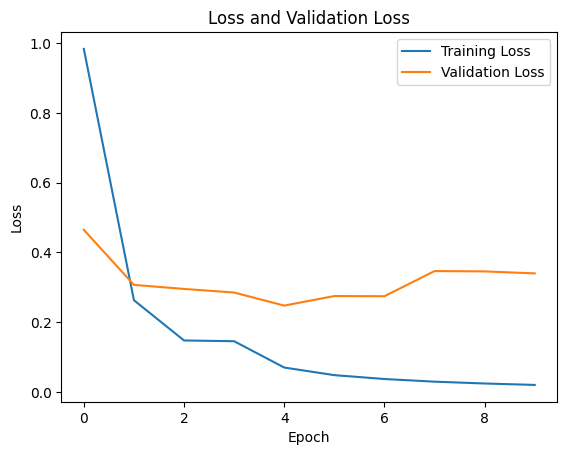

In [33]:
import matplotlib.pyplot as plt

# Plota a perda (loss) e a perda de validação (val_loss) durante o treinamento
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [34]:
# Salva arquivos em discos que podemos carregar sem treinar a rede neural novamente
model.save('ge_BiLSTM.h5')
np.save("X_test_BiLSTM.npy", X_test)
np.save("y_test_BiLSTM.npy", y_test)

In [35]:
from tensorflow.keras.models import load_model
import numpy as np

# Carrega arquivos pertinentes ao treinamento da rede neural e X_test e y_test (usados na avaliação de resultados)
model = load_model('ge_BiLSTM.h5')
X_test = np.load("X_test_BiLSTM.npy")
y_test = np.load("y_test_BiLSTM.npy")

In [36]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print('Acurácia final:', accuracy)

Acurácia final: 0.9546296000480652


In [37]:
# Fazer as previsões do modelo para o conjunto de teste
y_pred = model.predict(X_test)

34/34 [==============================] - 10s 237ms/step


In [38]:
#Transformar as previsões de volta em rótulos
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Calcular a matriz de confusão
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_true_labels, y_pred_labels)

conf_mat

array([[505,  19],
       [ 30, 526]], dtype=int64)

In [39]:
import pandas as pd

# Lê o arquivo .csv
df = pd.read_pickle("ge_df.pkl")

# Total de classes
classes = df['label'].nunique()

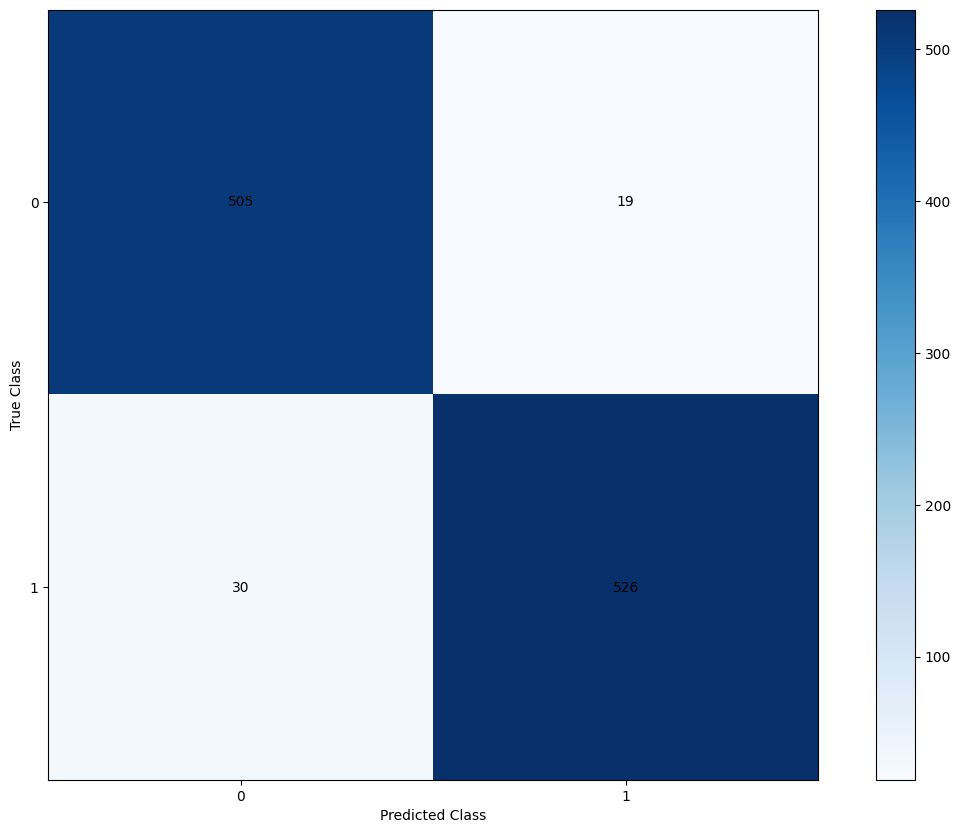

In [41]:
import matplotlib.pyplot as plt

# Define o tamanho da figura
plt.figure(figsize=(15, 10))

# Define mapa de cores
cmap = plt.cm.Blues

# Plota matriz de confusão
plt.imshow(conf_mat, cmap=cmap)
plt.colorbar()

# Adiciona rótulos a matriz
plt.xticks([int(i) for i in range(2)], [str(i) for i in range(2)])
plt.yticks([int(i) for i in range(2)], [str(i) for i in range(2)])

for i in range(classes):
    for j in range(classes):
        plt.text(j, i, str(conf_mat[i, j]), ha='center', va='center', color='white' if conf_mat[i, j] > len(y_true_labels)/ classes else 'black')

# Adiciona rótulos dos eixos
plt.xlabel('Predicted Class')
plt.ylabel('True Class')

# Mostra o plot
plt.show()

In [42]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

# Calcula precisão, recall e f1-score para cada classe
precisions = []
recalls = []
f1_scores = []
for i in range(classes):
    precision = precision_score(y_true=y_true_labels == i, y_pred=y_pred_labels == i, zero_division=0)
    recall = recall_score(y_true=y_true_labels == i, y_pred=y_pred_labels == i, zero_division=0)
    f1 = f1_score(y_true=y_true_labels == i, y_pred=y_pred_labels == i, zero_division=0)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)
    
# Printa resultados
for i in range(classes):
    print(f"Class '{i}': Precision={precisions[i]:.4f}, Recall={recalls[i]:.4f}, F1-Score={f1_scores[i]:.4f}")

# Calcula e printa a média dos f1-scores
f1_average = np.mean(f1_scores)
print(f"Average F1-Score: {f1_average:.4f}")

Class '0': Precision=0.9439, Recall=0.9637, F1-Score=0.9537
Class '1': Precision=0.9651, Recall=0.9460, F1-Score=0.9555
Average F1-Score: 0.9546


In [45]:
# Criei um dataframe simples com uma notícia só para aplicarmos a função preprocess_data

import pandas as pd
from nltk.tokenize import word_tokenize

value = """Depoimento de Cid incluiu golpe, vacina, joias e Abin

Ex-ajudante de ordens manteve versão de que não pode afirmar que Bolsonaro planejou um golpe; PF avalia ter fechado “pontos em aberto”

Em depoimento de mais de oito horas, o ex-ajudante de ordens de Jair Bolsonaro (PL) Mauro Cid foi questionado pela Polícia Federal (PF) sobre as investigações do plano golpista, do escândalo das joias, do registro falso de vacina e da “Abin paralela”.

A oitiva, nas palavras de agentes da PF, teve como objetivo fechar pontos que estavam ambíguos ou abertos de oitivas anteriores do militar da ativa.
Na avaliação de investigadores, o longo depoimento serviu para “fechar os pontos que estavam em aberto” da investigação.

Segundo agentes da investigação, Cid foi perguntado se tinha conhecimento de que o ex-presidente Jair Bolsonaro planejava um plano para se manter no poder.

O militar, porém, manteve a versão anterior, de acordo com integrantes da PF: de que foi discutida uma minuta de decretação de estado de defesa, mas que não pode afirmar que o então presidente planejava um golpe.
À PF, Cid disse que o ex-presidente se reuniu com generais após perder as eleições de outubro de 2022, mas negou ter participado do encontro em que o alto escalão das Forças Armadas teria debatido os termos da minuta de um golpe de Estado.

Segundo apurou a CNN, Cid também confirmou que Freire Gomes era contra a decretação de um estado de defesa, presente na chamada “minuta do golpe”.

O depoimento do militar corroborou outros já colhidos pela PF, como do ex-comandante do Exército, general Freire Gomes, e do ex-comandante da Aeronáutica, brigadeiro Carlos Baptista Junior.

A expectativa é de que Cid seja chamado novamente para depor nos próximos meses. Antes, a PF deve mandar comitiva aos Estados Unidos para tentar obter imagens e documentos na investigação do escândalo das joias.

Segundo relatos de investigadores, o depoimento de Cid foi satisfatório, e que o acordo de colaboração não está ameaçado, mas não se encerra colaboração de Cid nas investigações da PF. Ele é obrigado a colaborar até o fim do inquérito.
"""

# Crie um DataFrame com uma linha e a coluna 'data'
df_predict = pd.DataFrame(data={'Texto': [value]})

# Faz pré-processamento
preprocess_data(df_predict, 'Texto')

# Conversão dos dados para serem usados no modelo (rede neural)
preprocessed_articles = df_predict['Texto'].tolist()

sequences_test = []
for tokens in tqdm(preprocessed_articles):
    sequence = []
    for token in tokens:
        if token in word_to_index:
            sequence.append(word_to_index[token])
    sequences_test.append(sequence)
    
padded_example = pad_sequences(sequences_test, maxlen=max_length, padding='post')

# Fazer a previsão usando o modelo
predictions = model.predict(padded_example)

Removendo pontuação...


100%|██████████| 1/1 [00:00<00:00, 1000.79it/s]


Removendo números...


100%|██████████| 1/1 [00:00<00:00, 1000.55it/s]


Removendo acentos e símbolos diversos...


100%|██████████| 1/1 [00:00<00:00, 993.68it/s]


Convertendo para minúsculas...


100%|██████████| 1/1 [00:00<00:00, 1027.76it/s]
c:\Users\mathe\OneDrive\Área de Trabalho\TCC\Detector-de-Fake-News\.venv\lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Computando Lematização...
Processando segmento 1 de 10


100%|██████████| 1/1 [00:00<00:00, 31.24it/s]


Processando segmento 2 de 10


0it [00:00, ?it/s]


Processando segmento 3 de 10


0it [00:00, ?it/s]


Processando segmento 4 de 10


0it [00:00, ?it/s]


Processando segmento 5 de 10


0it [00:00, ?it/s]


Processando segmento 6 de 10


0it [00:00, ?it/s]


Processando segmento 7 de 10


0it [00:00, ?it/s]


Processando segmento 8 de 10


0it [00:00, ?it/s]


Processando segmento 9 de 10


0it [00:00, ?it/s]


Processando segmento 10 de 10


0it [00:00, ?it/s]


Remover tokens com espaços vazios...


100%|██████████| 1/1 [00:00<00:00, 333.17it/s]


1/1 [==============================] - 0s 329ms/step


In [46]:
predictions

array([[5.3749303e-04, 9.9946254e-01]], dtype=float32)

In [47]:
# Identificar a classe com a maior probabilidade
predicted_class = np.argmax(predictions)

# Exibir a classe prevista
print(f"Classe prevista: {predicted_class}")

Classe prevista: 1


In [50]:
from sklearn.preprocessing import LabelEncoder

import os

# Get the current working directory
script_dir = os.getcwd()

# Navigate up one level to the parent directory
parent_dir = os.path.dirname(script_dir)

# Construct the path to noticias_pre_processadas.csv
caminho_csv = os.path.join(parent_dir, "noticias_pre_processadas.csv")

# Read the CSV file into a DataFrame
df = pd.read_csv(caminho_csv)

# Cria um objeto LabelEncoder
le = LabelEncoder()

# Transforma os rótulos para variáveis categóricas
df['label'] = le.fit_transform(df['Categoria'])

original_class = le.inverse_transform([predicted_class]) # Transforma a classe predita de variável categórica de volta
print(f"Classe original: {original_class[0]}")

Classe original: true


In [51]:
# Criei um dataframe simples com uma notícia falsa só para aplicarmos a função preprocess_data

import pandas as pd
from nltk.tokenize import word_tokenize

value = """"Nova pesquisa surpreendente divulgada pelo Instituto de Estudos Alimentares revela que consumir uma barra de chocolate por dia pode impulsionar seu QI em até 10 pontos!

Um estudo abrangente conduzido ao longo de dois anos por uma equipe internacional de renomados cientistas descobriu uma conexão direta entre o consumo regular de chocolate e a melhoria das funções cognitivas. Segundo os pesquisadores, os componentes antioxidantes e estimulantes presentes no chocolate são responsáveis por desencadear reações positivas no cérebro, aumentando a atividade neuronal e melhorando a capacidade de concentração e resolução de problemas.

A pesquisa envolveu milhares de participantes de diferentes faixas etárias e origens étnicas, todos os quais relataram um aumento significativo em seus QIs após adotarem a rotina diária de consumir chocolate.

Os resultados deste estudo revolucionário estão prestes a mudar a maneira como entendemos o impacto dos alimentos em nosso funcionamento cerebral. Os cientistas agora estão investigando ainda mais para desenvolver diretrizes específicas sobre a quantidade ideal de consumo de chocolate para otimizar os benefícios cognitivos.

Portanto, se você quer dar um impulso à sua inteligência, talvez seja hora de adicionar uma barra de chocolate à sua dieta diária!"
"""

# Crie um DataFrame com uma linha e a coluna 'data'
df_predict = pd.DataFrame(data={'Texto': [value]})

# Faz pré-processamento
preprocess_data(df_predict, 'Texto')

# Conversão dos dados para serem usados no modelo (rede neural)
preprocessed_articles = df_predict['Texto'].tolist()

sequences_test = []
for tokens in tqdm(preprocessed_articles):
    sequence = []
    for token in tokens:
        if token in word_to_index:
            sequence.append(word_to_index[token])
    sequences_test.append(sequence)
    
padded_example = pad_sequences(sequences_test, maxlen=max_length, padding='post')

# Fazer a previsão usando o modelo
predictions = model.predict(padded_example)

Removendo pontuação...


100%|██████████| 1/1 [00:00<00:00, 985.27it/s]


Removendo números...


100%|██████████| 1/1 [00:00<00:00, 998.88it/s]


Removendo acentos e símbolos diversos...


100%|██████████| 1/1 [00:00<00:00, 999.83it/s]


Convertendo para minúsculas...


100%|██████████| 1/1 [00:00<00:00, 1040.77it/s]
c:\Users\mathe\OneDrive\Área de Trabalho\TCC\Detector-de-Fake-News\.venv\lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Computando Lematização...
Processando segmento 1 de 10


100%|██████████| 1/1 [00:00<00:00,  5.44it/s]


Processando segmento 2 de 10


0it [00:00, ?it/s]


Processando segmento 3 de 10


0it [00:00, ?it/s]


Processando segmento 4 de 10


0it [00:00, ?it/s]


Processando segmento 5 de 10


0it [00:00, ?it/s]


Processando segmento 6 de 10


0it [00:00, ?it/s]


Processando segmento 7 de 10


0it [00:00, ?it/s]


Processando segmento 8 de 10


0it [00:00, ?it/s]


Processando segmento 9 de 10


0it [00:00, ?it/s]


Processando segmento 10 de 10


0it [00:00, ?it/s]


Remover tokens com espaços vazios...


100%|██████████| 1/1 [00:00<00:00, 333.04it/s]


1/1 [==============================] - 0s 369ms/step


In [52]:
predictions

array([[9.995059e-01, 4.940804e-04]], dtype=float32)

In [53]:
# Identificar a classe com a maior probabilidade
predicted_class = np.argmax(predictions)

# Exibir a classe prevista
print(f"Classe prevista: {predicted_class}")

Classe prevista: 0


In [54]:
from sklearn.preprocessing import LabelEncoder

import os

# Get the current working directory
script_dir = os.getcwd()

# Navigate up one level to the parent directory
parent_dir = os.path.dirname(script_dir)

# Construct the path to noticias_pre_processadas.csv
caminho_csv = os.path.join(parent_dir, "noticias_pre_processadas.csv")

# Read the CSV file into a DataFrame
df = pd.read_csv(caminho_csv)

# Cria um objeto LabelEncoder
le = LabelEncoder()

# Transforma os rótulos para variáveis categóricas
df['label'] = le.fit_transform(df['Categoria'])

original_class = le.inverse_transform([predicted_class]) # Transforma a classe predita de variável categórica de volta
print(f"Classe original: {original_class[0]}")

Classe original: fake
